Below we right a program to calculate hurst exponent from time series data,
1.We will start with a program that computes hurst exponent using all the time series data.
2.We will then next write a program that computes hurst exponent for each individual month and we average the monthly values to get a hurst exponent.


Training set score: 0.98
Test set score: 0.98


Text(0, 0.5, 'log(R/s)')

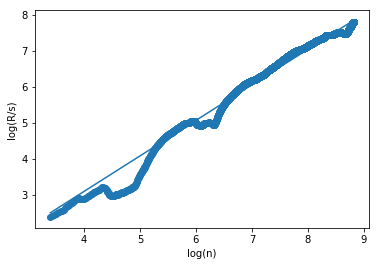

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math as mh
data_raw=pd.read_csv('SPY.csv')
rdata=data_raw['log return']
data=data_raw['Close']
dt=1
#def rescaled_analysis(data):
N=len(data)
n=30
xval=np.linspace(n,N,(N-n+1))
xval=xval.reshape(-1,1)
logx=np.log(xval)
yval=[0]*len(xval)
for t in range(n,N+1):
    tpx=data[0:t]
    Y=tpx-np.mean(tpx)
    Z=np.cumsum(Y)
    R=max(Z)-min(Z)
    S=np.std(tpx)
    yval[t-n]=(R/S)    
logy=np.log(yval)
logy=np.transpose(logy)
X_train, X_test, y_train, y_test = train_test_split(logx,logy,random_state=0)
lr = LinearRegression().fit(logx,logy)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
hurst_lr=lr.coef_[0] 
hurst_lr
#return hurst  
#rescaled_analysis(data)
plt.scatter(logx,logy)
plt.plot(logx,logx*hurst_lr+lr.intercept_)
plt.xlabel('log(n)')
plt.ylabel('log(R/s)')

computed hurst exponent value

In [213]:
hurst_lr

0.9878488506673432

compute standard deviation

In [297]:
standard_dev=lambda rdata,dt,hurst:np.sqrt(np.var(rdata)/dt**(2*hurst))
std_lr=standard_dev(rdata,dt,hurst_lr)    
std_lr

0.011453107280975629

computing dirft(mean) 

In [130]:
mean_frac=lambda rdata,dt,standard_dev:np.mean(rdata)/dt+(standard_dev**2)/2
mean_frac(rdata,dt,standard_dev(rdata,dt,hurst_lr))

0.00042565600593014175

we build algorithm to compute hurst exponent for 30 days,  
we then have a time series of hurst exponent numbers for varous months from jan 1 1920 to 25 october 2019

Text(0, 0.5, 'Hurst value')

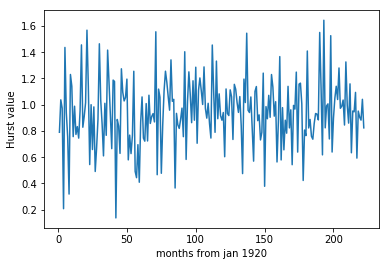

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mh
data_raw=pd.read_csv('SPY.csv')
rdata=data_raw['log return']
data=data_raw['Close']
dt=1

#function to comupte hurst exponent for a given period.
#note the data points must be not less than n=11
def rescaled_analysis(data):
    N=len(data)
    n=11
    xval=np.linspace(n,N,(N-n+1))
    logx=np.log(xval)
    yval=[0]*len(xval)
    for t in range(n,N+1):
        tpx=data[0:t]
        Y=tpx-np.mean(tpx)
        Z=np.cumsum(Y)
        R=max(Z)-min(Z)
        S=np.std(tpx)
        yval[t-n]=(R/S)    
    logy=np.log(yval)
    logy=np.transpose(logy)
    hurst=np.polyfit(logx,logy,1)[0]
    return hurst 

#get number of items in our dataset
N=len(data)
#pick data period of 30 days
m=30
#compute the number of 30 day peroids that canbe got from data
l=(round(N/m)-1)*m
i=0
maza=[0]*(round(N/m)-2)

#loop to compute hurst exponent for each period 
for k in range(m,l,m):
    zdata=data[i*m:k]
    maza[i]=rescaled_analysis(zdata)
    i=i+1
average=np.mean(maza)

#hurst is then comupted as average of all months
hurst_average_monthly=average
xvex=np.linspace(1,len(maza),len(maza))
plt.plot(xvex,maza)
plt.xlabel("months from jan 1920")
plt.ylabel('Hurst value')

compute volatility 


In [298]:
standard_dev=lambda rdata,dt,hurst:np.sqrt(np.var(rdata)/dt**(2*hurst))
standard_dev_monthly_av=standard_dev(rdata,dt,average) 
standard_dev_monthly_av

0.011453107280975629

In [221]:
hurst_average_monthly

0.9426346359792063

we compute the drift(mean)

In [95]:
mean_frac=lambda rdata,dt,standard_dev:np.mean(rdata)/dt+(standard_dev**2)/2
mean_frac(rdata,dt,standard_dev(rdata,dt,hurst_average_monthly))

0.00042565600593014175

From the plots of our monthly hurst exponent computstions we notice that although there are periods of volatility

in the plot of monthly hurst exponent values there appears that the values are oscilating about amean value and showing signs
of stationary.

We model our hurst exponent monthly data as autoregressive model.

In [222]:
#training Autoregresive model to predict next peorid hurst exponent
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
model=ARIMA(maza,order=(2,0,0))
result=model.fit()
pred=result.predict(start=len(maza),end=len(maza))
predmaz=maza.append(pred)
hurst_AR=pred[0]
print("hurst exponent predicted=",pred[0])
result.summary()

hurst exponent predicted= 0.9565352223702654


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:                     ARMA(2, 0)   Log Likelihood                 -12.645
Method:                       css-mle   S.D. of innovations              0.256
Date:                Tue, 28 Jul 2020   AIC                             33.290
Time:                        22:20:46   BIC                             46.901
Sample:                             0   HQIC                            38.785
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9428      0.015     64.165      0.000       0.914       0.972
ar.L1.y       -0.1404      0.067     -2.095      0.037      -0.272      -0.009
ar.L2.y       -0.0305      0.067     -0.456      0.649      -0.162       0.101
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.2995           -5.2413j            5.7236           -0.3158
AR.2           -2.2995           +5.2413j            5.7236            0.3158
-----------------------------------------------------------------------------
"""

In [223]:
hurst_AR

0.9565352223702654

In [224]:
standard_dev_AR=lambda rdata,dt,hurst:np.sqrt(np.var(rdata)/dt**(2*hurst))
std_AR=standard_dev_AR(rdata,dt,pred[0]) 
std_AR

0.011453107280975629

when we check the model parameters we notice that the coffients are greater than twice the standard error and are both significant.
notice that the predicted value is close to the value got by averaging all the monthly hurst exponent values.

In the next section we will try to price our options using various hurst exponent and volatility values we obtained using the 
models we have explore above

In [225]:
#Fractional BlackScholes model pricing
from scipy.stats import norm

Φ = norm.cdf

d1 = lambda S,K,r,τ,σ,H : (np.log(S/K) + r*τ + 0.5*(σ**2)*(τ**(2*H)))/(σ*np.sqrt(τ**(2*H)))

d2 = lambda S,K,r,τ,σ,H : d1(S,K,r,τ,σ,H) - σ*(np.sqrt(τ**(2*H)))
                                                                                             
def fbsm(S,K,r,τ,σ,H):       
  ''' fractional Black-Scholes value of a European call option '''
  return S*Φ(d1(S,K,r,τ,σ,H)) - (K*np.exp(-r*τ))*Φ(d2(S,K,r,τ,σ,H))

In [226]:
#Standard Black-Scholes model pricing
Φ = norm.cdf

dstock1 = lambda S,K,r,τ,σ: ((np.log(S/K) + (r + 0.5*σ**2)*τ))/(σ*np.sqrt(τ))

dstock2 = lambda S,K,r,τ,σ: dstock1(S,K,r,τ,σ) - (σ*np.sqrt(τ))

def sbsm(S,K,r,τ,σ):    
  ''' fractional Black-Scholes value of a European call option '''
  return S*Φ(dstock1(S,K,r,τ,σ)) - (K*np.exp(-r*τ))*Φ(dstock2(S,K,r,τ,σ))

In [263]:
#here we try to price our call options using historical data by using our Autoregressive model (AR) generated
#from the monthly hurst exponent data
options_data=pd.read_csv('SPY_OptionTrades_Raw_IV.csv')
fsbsm_price_AR=[0]*len(options_data['Price_strike'])
for i in range(0,len(options_data['Price_strike'])):
    fsbsm_price_AR[i]=fbsm(297.92,options_data['Price_strike'][i],0.0174,options_data['Duration'][i]/30,std_AR,hurst_AR)

In [265]:
#here we try to price our call options using historical data by using our Autoregressive model (AR)
#from the monthly hurst exponent data
fsbsm_price_monthly_av=[0]*len(options_data['Price_strike'])
for i in range(0,len(options_data['Price_strike'])):
    fsbsm_price_monthly_av[i]=fbsm(297.92,options_data['Price_strike'][i],0.0174,options_data['Duration'][i]/30,standard_dev_monthly_av,hurst_average_monthly)


In [267]:
#here we try to price our call options using historical data by using our a linear model for our historical stock data
fsbsm_price_lr=[0]*len(options_data['Price_strike'])
for i in range(0,len(options_data['Price_strike'])):
    fsbsm_price_lr[i]=fbsm(297.92,options_data['Price_strike'][i],0.0174,options_data['Duration'][i]/30,std_lr,hurst_lr)

In [268]:
sbsm_price=[0]*len(options_data['Price_strike'])
a=np.std(rdata)
for i in range(0,len(options_data['Price_strike'])):
    sbsm_price[i]=sbsm(297.92,options_data['Price_strike'][i],0.0174,(options_data['Duration'][i]/30),a)

In [299]:
a

0.011453107280975629

In [274]:
from sklearn.metrics import mean_squared_error as MSE

error_AR=MSE(options_data['Price_strike'],fsbsm_price_AR)
error_AR

82660.05756216317

In [275]:
error_monthly_av=MSE(options_data['Price_strike'], fsbsm_price_monthly_av)
error_monthly_av

82668.39843810789

In [276]:
error_lr=MSE(options_data['Price_strike'],   fsbsm_price_lr)
error_lr

82639.6263275395

In [277]:
sbsm_price=MSE(options_data['Price_strike'],   sbsm_price)
sbsm_price

82804.44884097665

In [294]:
sumdata=([error_AR,error_monthly_av,error_lr,sbsm_price])
heading=(["error_AR","error_monthly_av","error_lr","sbsm_price"])

In [296]:
sumdata=pd.DataFrame(sumdata,heading, columns= ["means square error"])
sumdata

,means square error
error_AR,82660.057562
error_monthly_av,82668.398438
error_lr,82639.626328
sbsm_price,82804.448841
